In [1]:
from drone_detector.utils import * 
from drone_detector.imports import *
import rasterio.mask as rio_mask
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")

Function definitions etc, should maybe be moved into separate .py file.

In [2]:
from shapely.geometry import LineString, box, Point
from shapely.geometry.polygon import orient
from shapely.ops import nearest_points

def get_len(geom):
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_len)

def get_three_point_diams(geom):
    """Approximate polygon diameter by creating three lines that intersect the polygon 
    in three different points. """
    d = get_len(geom)
    mrr = geom.minimum_rotated_rectangle
    mrr = orient(mrr)
    mrr_x, mrr_y = mrr.exterior.coords.xy
    a_ix = list(mrr_y).index(min(mrr_y))
    b_ix = a_ix + 1 if a_ix < 3 else 0
    c_ix = b_ix + 1 if b_ix < 3 else 0
    d_ix = c_ix + 1 if c_ix < 3 else 0 
    ab = LineString([Point(mrr_x[a_ix], mrr_y[a_ix]), Point(mrr_x[b_ix], mrr_y[b_ix])])
    ad = LineString([Point(mrr_x[a_ix], mrr_y[a_ix]), Point(mrr_x[d_ix], mrr_y[d_ix])])
    if ab.length > ad.length:
        maxline = ab
        max_ort = LineString([Point(mrr_x[d_ix], mrr_y[d_ix]), Point(mrr_x[c_ix], mrr_y[c_ix])])
    else:
        maxline = ad
        max_ort = LineString([Point(mrr_x[b_ix], mrr_y[b_ix]), Point(mrr_x[c_ix], mrr_y[c_ix])]) 
    bot_a, bot_b = maxline.boundary
    top_a, top_b = max_ort.boundary
    if top_a.y == top_b.y: # horizontal
        line_05 = LineString([Point(min(top_a.x, top_b.x) + 0.05*d, top_a.y), 
                              Point(min(bot_a.x, bot_b.x) + 0.05*d, bot_a.y)])
        line_50 = LineString([Point(min(top_a.x, top_b.x) + 0.5*d, top_a.y), 
                              Point(min(bot_a.x, bot_b.x) + 0.5*d, bot_a.y)])
        line_95 = LineString([Point(max(top_a.x, top_b.x) - 0.05*d, top_b.y),
                              Point(max(bot_a.x, bot_b.x) - 0.05*d, bot_b.y)])
    elif top_a.x == top_b.x: # vertical
        line_05 = LineString([Point(top_a.x, min(top_a.y,  top_b.y) + 0.05*d), 
                              Point(bot_a.x, min(bot_a.y,  bot_b.y) + 0.05*d)])
        line_50 = LineString([Point(top_a.x, min(top_a.y,  top_b.y) + 0.5*d), 
                              Point(bot_a.x, min(bot_a.y,  bot_b.y) + 0.5*d)])
        line_95 = LineString([Point(top_b.x, max(top_a.y,  top_b.y) - 0.05*d), 
                              Point(bot_b.x, max(bot_a.y,  bot_b.y) - 0.05*d)])
    else: # we do geometry, solve <x,y> = <x_1,y_1> + t<1,m>
        k = (bot_b.y - bot_a.y) / (bot_b.x - bot_a.x)
        mul = 1 if k > 0 else -1
        top_x_05 = top_a.x + mul * np.sqrt(((0.05*d)**2)/(1+k**2))
        top_x_50 = top_a.x + mul * np.sqrt(((0.5*d)**2)/(1+k**2))
        top_x_95 = top_a.x + mul * np.sqrt(((0.95*d)**2)/(1+k**2))
        top_y_05 = top_a.y + np.sqrt(((0.05*d*k)**2)/(1+k**2))
        top_y_50 = top_a.y + np.sqrt(((0.5*d*k)**2)/(1+k**2))
        top_y_95 = top_a.y + np.sqrt(((0.95*d*k)**2)/(1+k**2))
        bot_x_05 = bot_a.x + mul * np.sqrt(((0.05*d)**2)/(1+k**2))
        bot_x_50 = bot_a.x + mul * np.sqrt(((0.5*d)**2)/(1+k**2))
        bot_x_95 = bot_a.x + mul * np.sqrt(((0.95*d)**2)/(1+k**2))
        bot_y_05 = bot_a.y + np.sqrt(((0.05*d*k)**2)/(1+k**2))
        bot_y_50 = bot_a.y + np.sqrt(((0.5*d*k)**2)/(1+k**2))
        bot_y_95 = bot_a.y + np.sqrt(((0.95*d*k)**2)/(1+k**2))
        line_05 = LineString([Point(top_x_05, top_y_05), Point(bot_x_05, bot_y_05)])
        line_50 = LineString([Point(top_x_50, top_y_50), Point(bot_x_50, bot_y_50)])
        line_95 = LineString([Point(top_x_95, top_y_95), Point(bot_x_95, bot_y_95)])
        
    return line_05.intersection(geom).length, line_50.intersection(geom).length, line_95.intersection(geom).length

def cut_cone_volume(geom):
    """Estimate the volume for the polygon by assuming that it is constructed from two 
    truncated right circular truncated cones.
    """
    h = get_len(geom)/2
    d_05, d_50, d_95 = get_three_point_diams(geom)
    r_05 = d_05/2
    r_50 = d_50/2
    r_95 = d_95/2
    V_1 = (np.pi*h*(r_05**2 + r_05*r_50 + r_50**2))/3
    V_2 = (np.pi*h*(r_95**2 + r_95*r_50 + r_50**2))/3
    return V_1 + V_2

def get_len_in_plot(geom, circles):
    "Use the longest side of the minimum rotated rectangle around a polygon as the proxy for trunk length"
    matching_circle = circles[circles.intersects(geom)].iloc[0].geometry
    geom = copy(geom.intersection(matching_circle))
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_len)

# Comparison of plot characteristics and results

Here we first compare the annotations and predictions in field plot level metrics, and then do the same for predictions and field data. Comparison between annotations and predictions is done with all data within the virtual plot, whereas the comparisons between predictions and field data are done with the predictions intersecting the field plot circle.

# Hiidenportti

Read data and do some wrangling. Hiidenportti data comparisons are done only with five test virtual plots.

In [3]:
field_data_path = Path('../data/hiidenportti')
anns = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')
preds = gpd.read_file('../results/hiidenportti/merged_all.geojson')
plot_circles = gpd.read_file(field_data_path/'plot_circles.geojson')
field_data = pd.read_csv(field_data_path/'all_plot_data.csv')
virtual_plot_grid = gpd.read_file(field_data_path/'envelopes_with_trees.geojson')
natura_areas = gpd.read_file(field_data_path/'hiidenportti_natura.geojson')

Filter plot circles so that only those present in virtual plots remain.

In [4]:
plot_circles['in_vplot'] = plot_circles.apply(lambda row: 1 if any(virtual_plot_grid.geometry.contains(row.geometry)) 
                                              else 0, axis=1)
plot_circles['id'] = plot_circles['id'].astype(int)
field_data = field_data[field_data.id.isin(plot_circles[plot_circles.in_vplot==1].id.unique())]
field_data.rename(columns= {c: c.replace('.','_') for c in field_data.columns}, inplace=True)
dw_cols = ['id'] + [c for c in field_data.columns if 'dw' in c]
plot_dw_data = field_data[dw_cols].copy()

In [5]:
plot_circles = plot_circles[plot_circles.in_vplot == 1]

Convert `n_dw` (number of deadwood stems per hectare), `n_ddw` and `n_udw` to signify number of deadwood stems in circular plot with 9m radius.

In [7]:
plot_dw_data['n_dw_plot'] = np.round((plot_dw_data['n_dw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_ddw_plot'] = np.round((plot_dw_data['n_ddw']/10000)*np.pi*9**2).astype(int)
plot_dw_data['n_udw_plot'] = plot_dw_data.n_dw_plot - plot_dw_data.n_ddw_plot

Some helper functions for data matching.

In [8]:
def match_circular_plot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return int(p.id)
        
def match_vplot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return f'{p.id}_{p.level_1}'

In [10]:
anns['plot_id'] = anns.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
anns_in_plots = anns[anns.geometry.intersects(plot_circles.geometry.unary_union)].copy()
anns_in_plots['plot_id'] = anns_in_plots.plot_id.astype(int)

Add relevant information to predictions.

In [11]:
preds['conservation'] = preds.geometry.apply(lambda row: 1 if any(natura_areas.geometry.contains(row))
                                                         else 0)

In [12]:
preds['plot_id'] = preds.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
preds_in_plots = preds[preds.geometry.intersects(plot_circles.geometry.unary_union)].copy()
preds_in_plots['plot_id'] = preds_in_plots.plot_id.astype(int)
preds['vplot_id'] = preds.apply(lambda row: match_vplot(row, virtual_plot_grid), axis=1)

Filter only test areas

In [13]:
anns_in_plots = anns_in_plots[anns_in_plots.plot_id.isin(preds_in_plots.plot_id.unique())]
plot_dw_data = plot_dw_data[plot_dw_data.id.isin(preds_in_plots.plot_id.unique())]
anns = anns[anns.vplot_id.isin(preds.vplot_id.unique())]

## Predictions vs annotations, with all data present in virtual plots

First crosstab the numbers of different deadwood types.

In [14]:
pd.crosstab(anns.conservation, anns.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,546,88,634
1,717,196,913
All,1263,284,1547


In [15]:
pd.crosstab(preds.conservation, preds.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,742,87,829
1,923,171,1094
All,1665,258,1923


Add tree length and diameter estimations.

In [16]:
anns['tree_length'] = anns.geometry.apply(get_len)
preds['tree_length'] = preds.geometry.apply(get_len)
anns['diam'] = anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
preds['diam'] = preds.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000

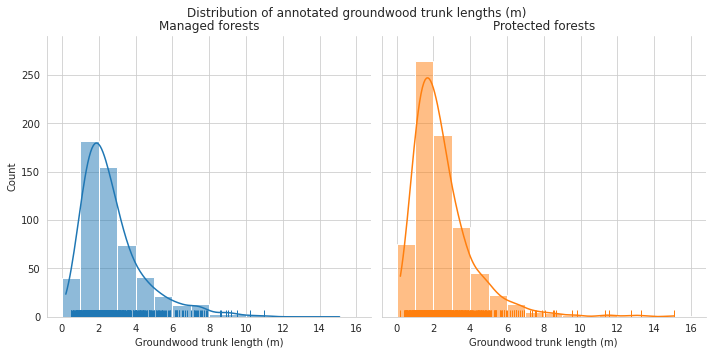

In [17]:
g = sns.displot(data=anns[anns.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(anns.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

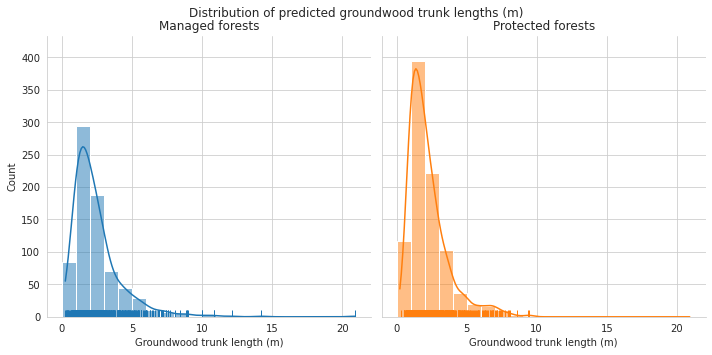

In [18]:
g = sns.displot(data=preds[preds.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(preds.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

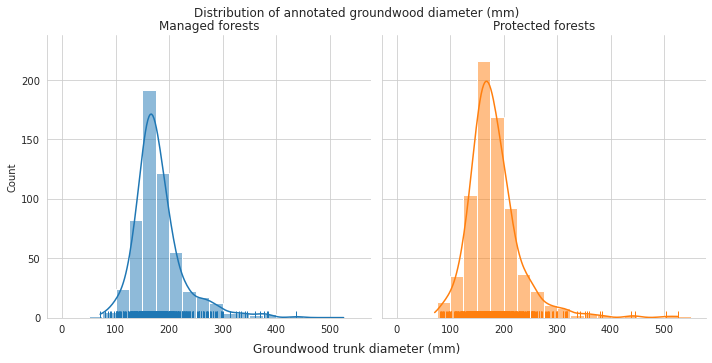

In [19]:
g = sns.displot(data=anns[(anns.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(anns[(anns.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

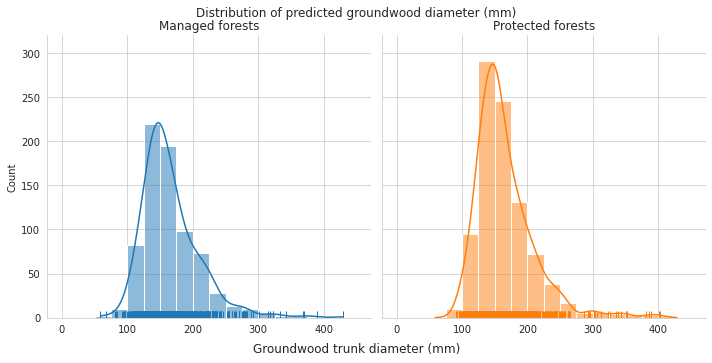

In [20]:
g = sns.displot(data=preds[(preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(preds[(preds.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [21]:
anns['v_ddw'] = anns.geometry.apply(cut_cone_volume)
preds['v_ddw'] = preds.geometry.apply(cut_cone_volume)

In [22]:
virtual_plot_grid['vplot_id'] = virtual_plot_grid.apply(lambda p: f'{p.id}_{p.level_1}', axis=1)

test_natura_areas = natura_areas.overlay(virtual_plot_grid[virtual_plot_grid.vplot_id.isin(preds.vplot_id.unique())])

test_vplot_area = virtual_plot_grid[virtual_plot_grid.vplot_id.isin(preds.vplot_id.unique())].area.sum()
test_cons_area = test_natura_areas.area.sum()
test_man_area = test_vplot_area - test_cons_area
test_man_ha = test_man_area / 10000
test_cons_ha = test_cons_area / 10000

In [23]:
ann_est_v_man = anns[(anns.layer=='groundwood')&(anns.conservation==0)].v_ddw.sum()/test_man_ha
ann_est_v_cons = anns[(anns.layer=='groundwood')&(anns.conservation==1)].v_ddw.sum()/test_cons_ha
ann_est_v_test = anns[(anns.layer=='groundwood')].v_ddw.sum()/(test_vplot_area/10000)

In [24]:
pred_est_v_man = preds[(preds.layer=='groundwood')&(preds.conservation==0)].v_ddw.sum()/test_man_ha
pred_est_v_cons = preds[(preds.layer=='groundwood')&(preds.conservation==1)].v_ddw.sum()/test_cons_ha
pred_est_v_test = preds[(preds.layer=='groundwood')].v_ddw.sum()/(test_vplot_area/10000)

In [25]:
print(f'Estimated groundwood volume in managed forests, based on annotations: {ann_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on annotations: {ann_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on annotations: {ann_est_v_test:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on annotations: 9.60 ha/m³
Estimated groundwood volume in conserved forests, based on annotations: 15.04 ha/m³
Estimated groundwood volume in both types, based on annotations: 12.14 ha/m³


In [26]:
print(f'Estimated groundwood volume in managed forests, based on predictions: {pred_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on predictions: {pred_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on predictions: {pred_est_v_test:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on predictions: 12.08 ha/m³
Estimated groundwood volume in conserved forests, based on predictions: 15.23 ha/m³
Estimated groundwood volume in both types, based on predictions: 13.55 ha/m³


## Predictions vs field data, with only predictions present in field plots

Count the number of annotated deadwood instances in each circular field plot, as well as note which of the circular plots are located in the conserved areas.

In [27]:
plot_dw_data['n_dw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==2].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==1].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==1].plot_id.unique() else 0, axis=1)
plot_dw_data['geometry'] = plot_dw_data.apply(lambda row: plot_circles[plot_circles.id == row.id].geometry.iloc[0], 
                                              axis=1)
plot_dw_data = gpd.GeoDataFrame(plot_dw_data, crs=plot_circles.crs)
plot_dw_data['conservation'] = plot_dw_data.apply(lambda row: 1 if any(natura_areas.geometry.contains(row.geometry))
                                                  else 0, axis=1)

In [28]:
plot_dw_data['n_dw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[preds_in_plots.label==2].plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots[preds_in_plots.label==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[preds_in_plots.label==1].plot_id.value_counts()[row.id] 
                                              if row.id in preds_in_plots[preds_in_plots.label==1].plot_id.unique() else 0, axis=1)

In [29]:
plot_dw_data.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 
                                                       'n_ddw_ann', 'n_udw_ann',
                                                       'n_ddw_pred', 'n_udw_pred'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_ddw_pred,n_udw_ann,n_udw_plot,n_udw_pred
conservation,,,,,,
0,22,21,29,6,5,3
1,41,51,46,14,24,12
All,63,72,75,20,29,15


Get plot-wise canopy cover percentage based on LiDAR derived canopy height model as the percentage of plot area with height more than 2 meters.

In [30]:
pcts = []

with rio.open('../../data/raw/hiidenportti/full_mosaics/CHM_Hiidenportti_epsg.tif') as src:
    crs = src.crs
    for row in plot_dw_data.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

In [31]:
plot_dw_data['canopy_cover_pct'] = pcts

Plot the relationship between annotated deadwood and field data.

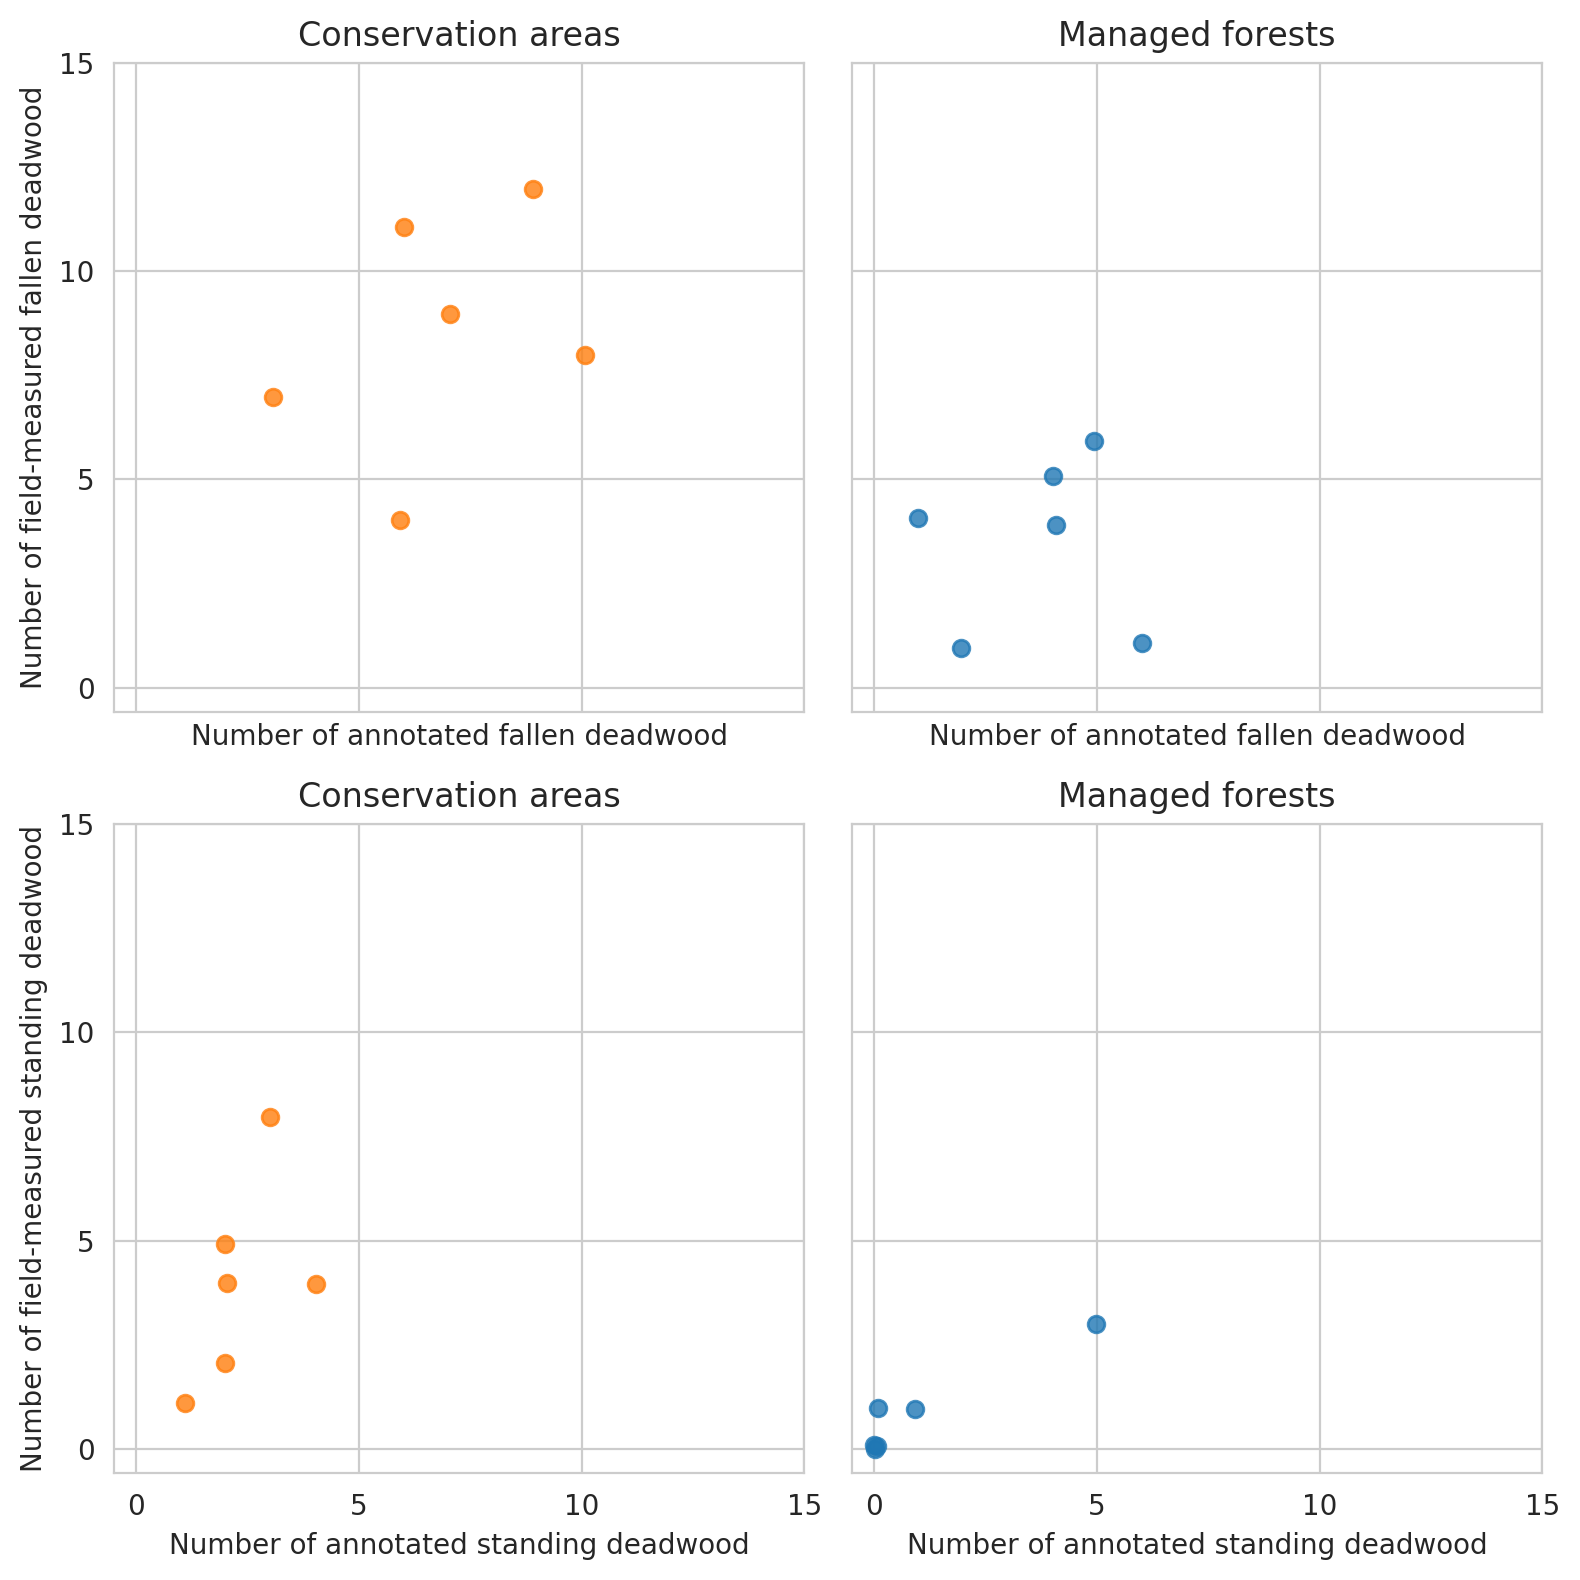

In [32]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,16,5))
ax[0,0].set_yticklabels(range(0,16,5))
ax[0,0].set_xticks(range(0,16,5))
ax[0,0].set_xticklabels(range(0,16,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,16,5))
ax[0,1].set_yticklabels(range(0,16,5))
ax[0,1].set_xticks(range(0,16,5))
ax[0,1].set_xticklabels(range(0,16,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,16,5))
ax[1,0].set_yticklabels(range(0,16,5))
ax[1,0].set_yticks(range(0,16,5))
ax[1,0].set_yticklabels(range(0,16,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,16,5))
ax[1,1].set_yticklabels(range(0,16,5))
ax[1,1].set_xticks(range(0,16,5))
ax[1,1].set_xticklabels(range(0,16,5))
plt.tight_layout()

Same for field data and predictions

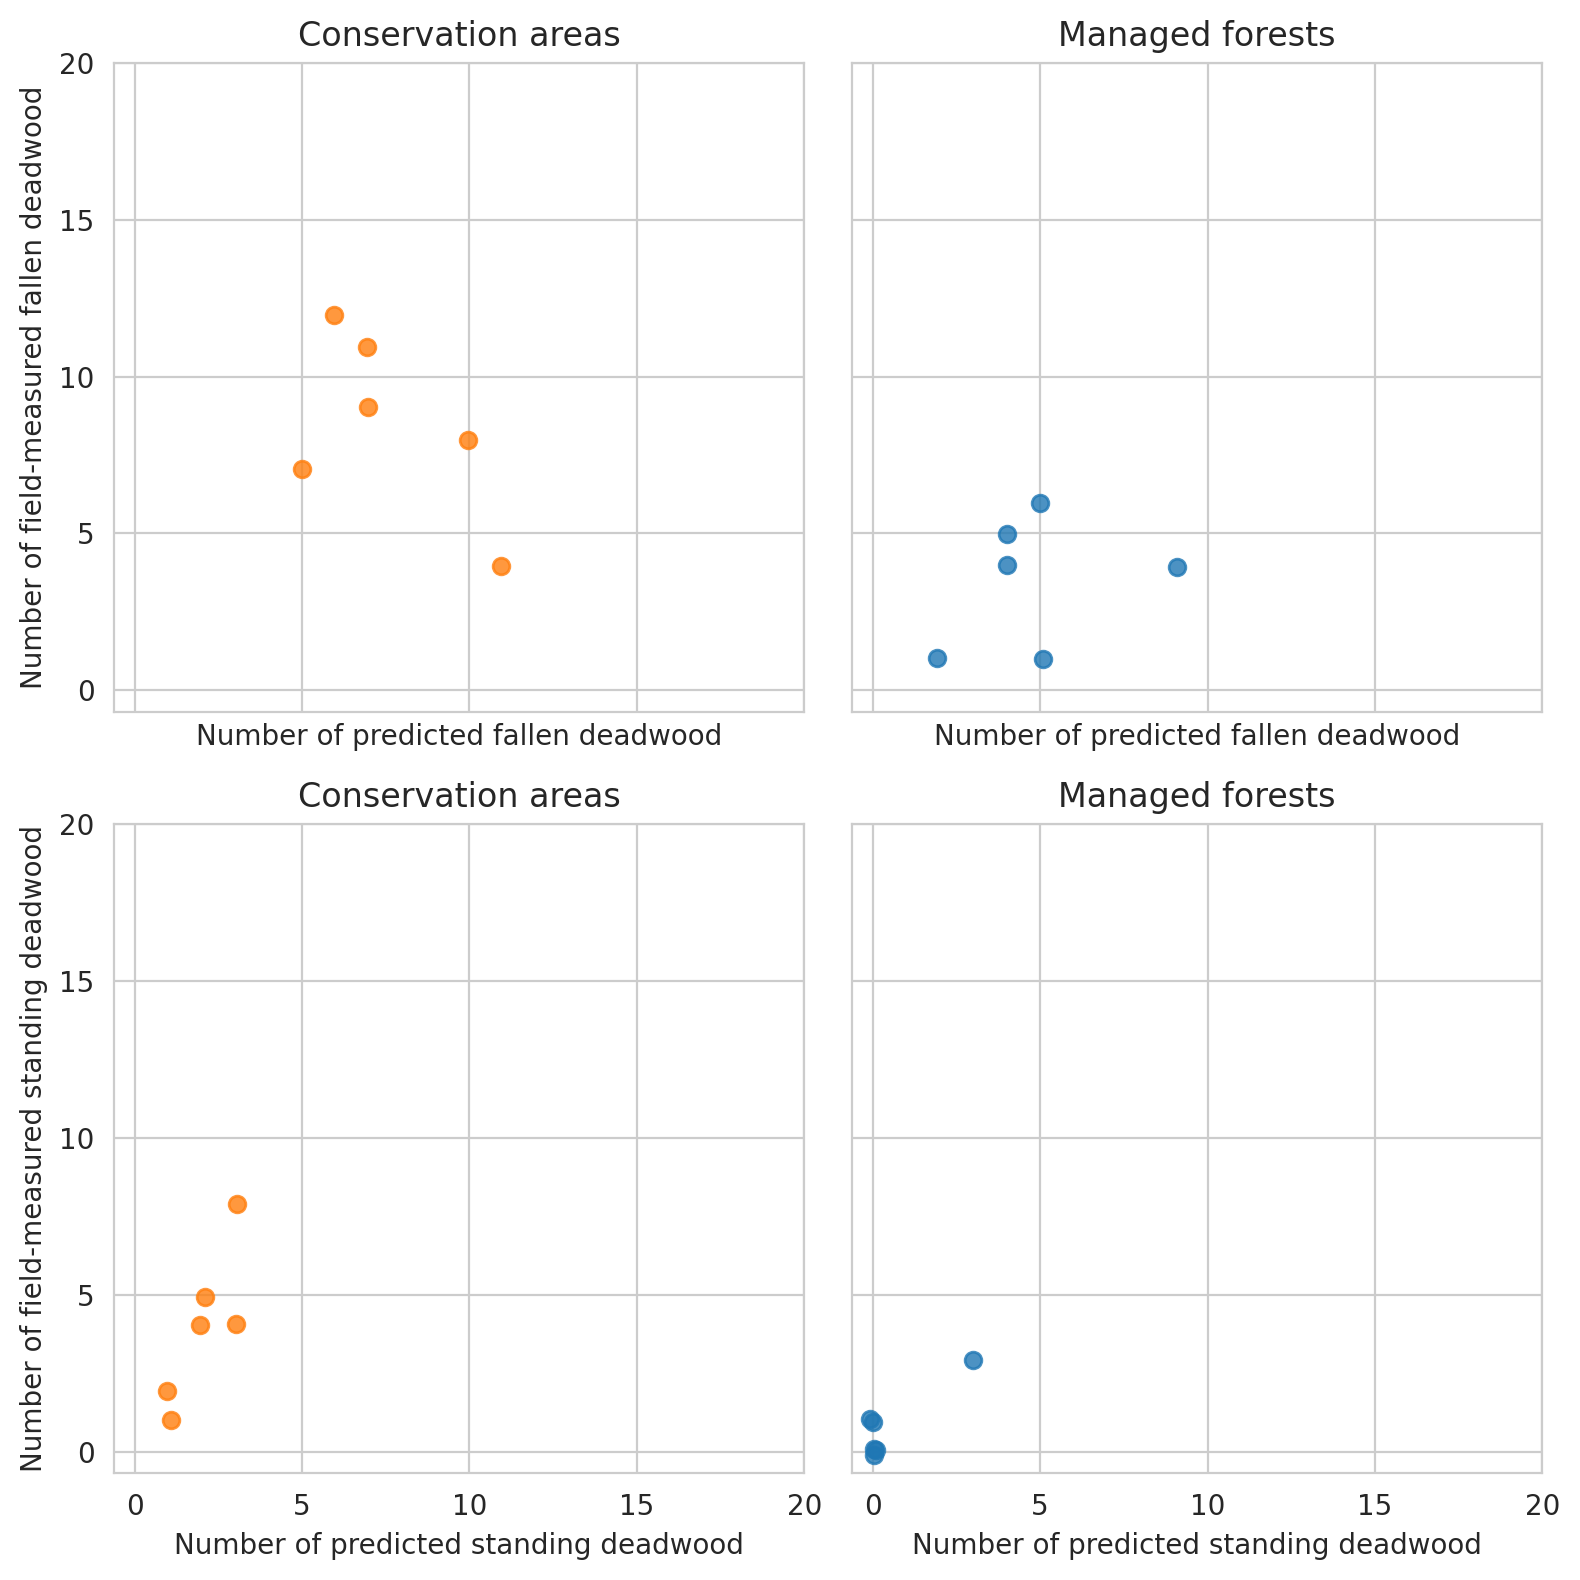

In [254]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xticks(range(0,21,5))
ax[0,0].set_xticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of predicted fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xticks(range(0,21,5))
ax[0,1].set_xticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of predicted fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of predicted standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
ax[1,0].set_xticks(range(0,21,5))
ax[1,0].set_xticklabels(range(0,21,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of predicted standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
ax[1,1].set_xticks(range(0,21,5))
ax[1,1].set_xticklabels(range(0,21,5))
plt.tight_layout()

Read individual tree measurements, and convert `l` from decimeters to meters.

In [34]:
tree_data = pd.read_csv(field_data_path/'hiidenportti_singletree.csv')
tree_data = tree_data[tree_data.plot_id.isin(plot_dw_data.id.unique())]
tree_data['l'] /= 10

Add information about conservation area to tree data.

In [35]:
tree_data['conservation'] = tree_data.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

In [36]:
preds_in_plots['conservation'] = preds_in_plots.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

In [37]:
anns_in_plots['tree_length'] = anns_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)
preds_in_plots['tree_length'] = preds_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)

Compare the distributions of the downed trunk lengths. Both graphs only take the parts within the plots into account. Lengths are binned into 1m bins.

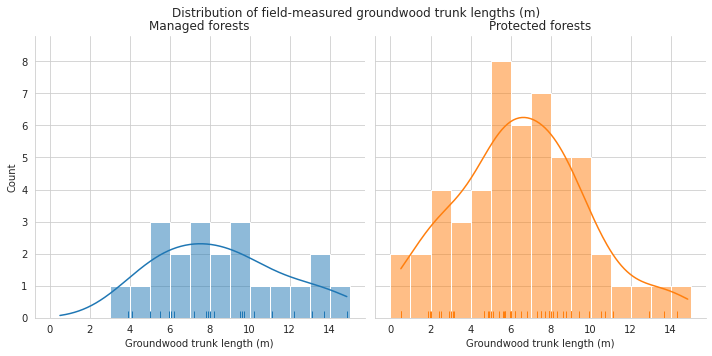

In [38]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.l > 0)], x='l', 
                hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=1, binrange=(0, max(tree_data[tree_data.tree_class == 4].l))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

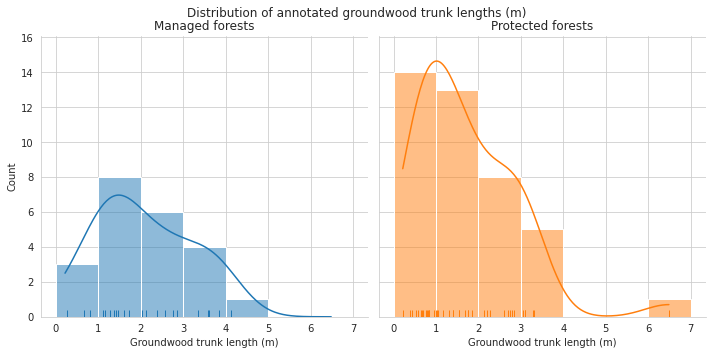

In [39]:
g = sns.displot(data=anns_in_plots[anns_in_plots.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(anns_in_plots.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

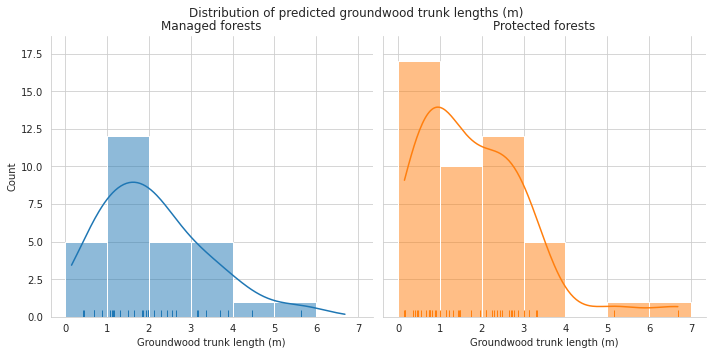

In [40]:
g = sns.displot(data=preds_in_plots[preds_in_plots.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(preds_in_plots.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

As expected, annotated trunks are clearly on average shorter than field measured.

Compare the measured DBH for downed trees and estimated diameter of annotated downed deadwood. For annotated deadwood, the diameter is estimated for the whole tree, not only for the part within the field plot. DBHs are binned into 50mm bins.

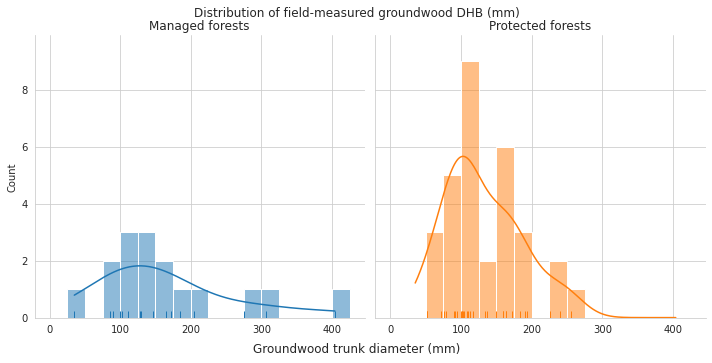

In [41]:
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)], x='dbh', hue='conservation', 
                col='conservation', kde=True, rug=True, legend=False, binwidth=25,
                binrange=(0, max(tree_data[(tree_data.tree_class == 4)].dbh))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

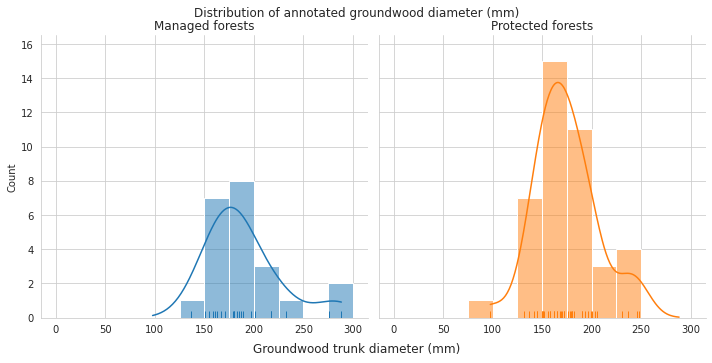

In [42]:
anns_in_plots['diam'] = anns_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=anns_in_plots[(anns_in_plots.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(anns_in_plots[(anns_in_plots.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

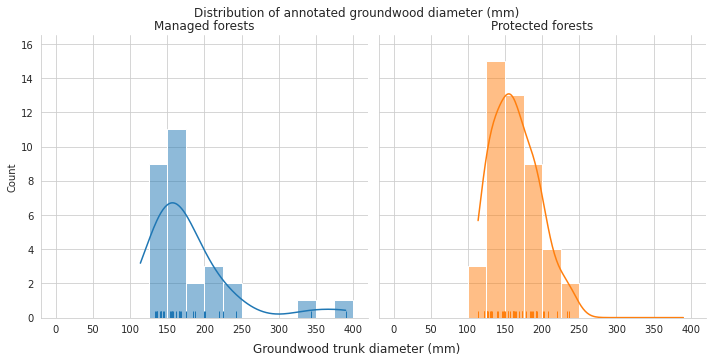

In [43]:
preds_in_plots['diam'] = preds_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=preds_in_plots[(preds_in_plots.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(preds_in_plots[(preds_in_plots.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [44]:
pd.pivot_table(data=tree_data[(tree_data.tree_class == 4)&(tree_data.dbh>0)],
               index=['conservation'], values=['l', 'dbh'],
               aggfunc=['mean', 'median'], margins=True)

mean           median         
                     dbh         l    dbh        l
conservation                                      
0             165.000000  8.735392    138  8.75000
1             131.806452  7.387939    112  7.90000
All           143.106383  7.846646    128  7.91442

In [45]:
pd.pivot_table(data=anns_in_plots[anns_in_plots.groundwood==2], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'median'], margins=True)

mean                  median            
                    diam tree_length        diam tree_length
conservation                                                
0             189.604763    2.095525  181.108520    1.872981
1             174.181904    1.712194  170.433030    1.412081
All           179.567664    1.846056  175.749122    1.551973

In [46]:
pd.pivot_table(data=preds_in_plots[preds_in_plots.label==2], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'median'], margins=True)

mean                  median            
                    diam tree_length        diam tree_length
conservation                                                
0             180.330085    2.108754  161.211315    1.938611
1             163.280782    1.776469  160.750894    1.467861
All           169.873179    1.904952  160.949415    1.747242

Plot the total lengths of groundwood located within a single field plot.

In [47]:
plot_dw_data['l_gw_field'] = plot_dw_data.apply(lambda row: tree_data[(tree_data.plot_id == row.id) &
                                                                      (tree_data.tree_class == 4)].l.sum()
                                              , axis=1)
plot_dw_data['l_gw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer == 'groundwood')
                                                                       ].tree_length.sum()
                                              , axis=1)

In [48]:
plot_dw_data['l_gw_pred'] = plot_dw_data.apply(lambda row: preds_in_plots[(preds_in_plots.plot_id == row.id) &
                                                                        (preds_in_plots.layer == 'groundwood')
                                                                       ].tree_length.sum()
                                              , axis=1)

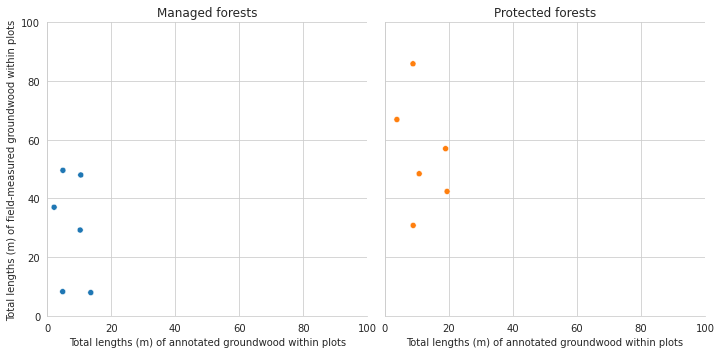

In [49]:
g = sns.relplot(data=plot_dw_data, x='l_gw_ann', y='l_ddw', col='conservation', hue='conservation', alpha=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,101,20))
g.axes[0,0].set_xticks(range(0,101,20))
g.axes[0,1].set_xticks(range(0,101,20))
g.set_ylabels('Total lengths (m) of field-measured groundwood within plots')
g.set_xlabels('Total lengths (m) of annotated groundwood within plots')
plt.show()

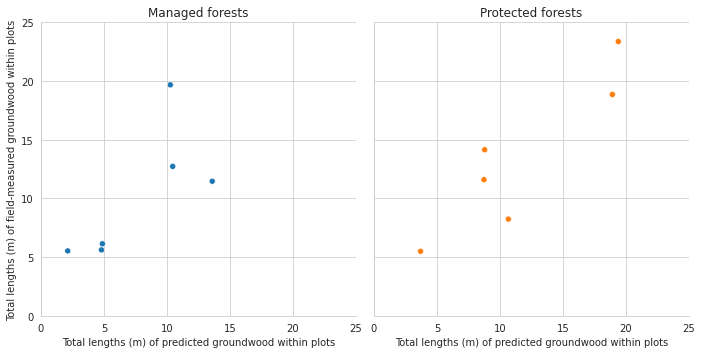

In [50]:
g = sns.relplot(data=plot_dw_data, x='l_gw_ann', y='l_gw_pred', col='conservation', hue='conservation', alpha=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,26,5))
g.axes[0,0].set_xticks(range(0,26,5))
g.axes[0,1].set_xticks(range(0,26,5))
g.set_ylabels('Total lengths (m) of field-measured groundwood within plots')
g.set_xlabels('Total lengths (m) of predicted groundwood within plots')
plt.show()

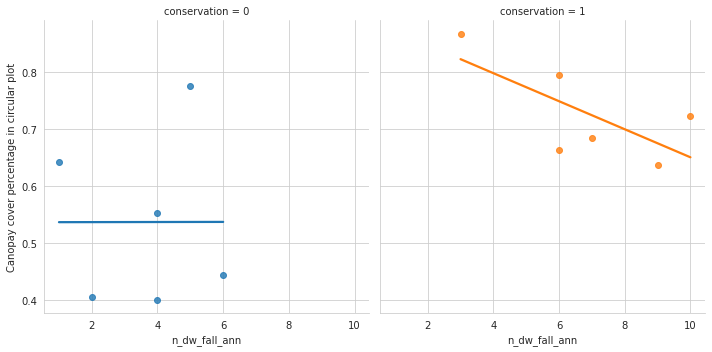

In [51]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_ann', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopay cover percentage in circular plot')
g.set_xlabels('n_dw_fall_ann')

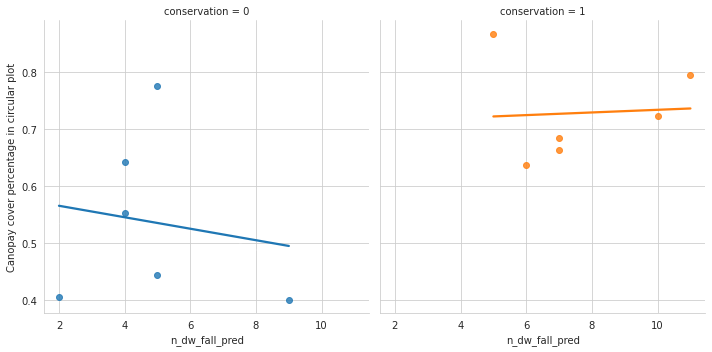

In [52]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_pred', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopay cover percentage in circular plot')
g.set_xlabels('n_dw_fall_pred')


Plot the difference in the numbers of annotated deadwood.

In [53]:
plot_dw_data['n_ddw_plot_diff'] = plot_dw_data.n_ddw_plot - plot_dw_data.n_ddw_ann

In [54]:
plot_dw_data['n_udw_plot_diff'] = plot_dw_data.n_udw_plot - plot_dw_data.n_udw_ann

Text(0.5, 1.0, 'Conserved forests')

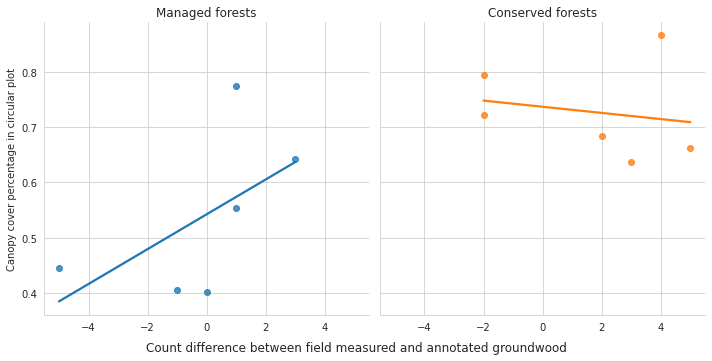

In [55]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated groundwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

Text(0.5, 1.0, 'Conserved forests')

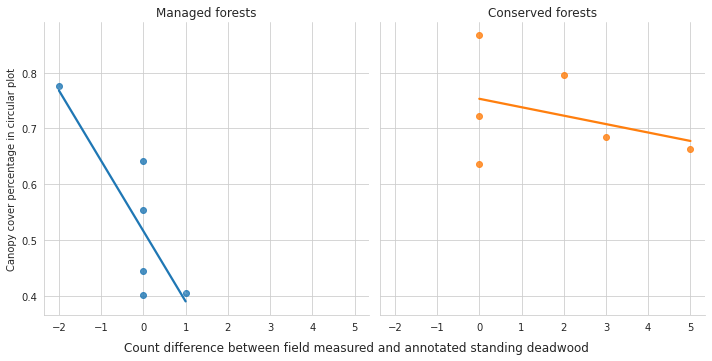

In [56]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

In [57]:
plot_dw_data['l_udw_mean'] = plot_dw_data.apply(lambda row: tree_data[(tree_data.plot_id==row.id)&
                                                                 (tree_data.tree_class==3)].l.mean(), axis=1)
plot_dw_data['d_udw_mean'] = plot_dw_data.apply(lambda row: tree_data[(tree_data.plot_id==row.id)&
                                                                 (tree_data.tree_class==3)].dbh.mean(), axis=1)
plot_dw_data['l_udw_mean'].fillna(value=0, inplace=True)
plot_dw_data['d_udw_mean'].fillna(value=0, inplace=True)


Text(0.5, 1.0, 'Conserved forests')

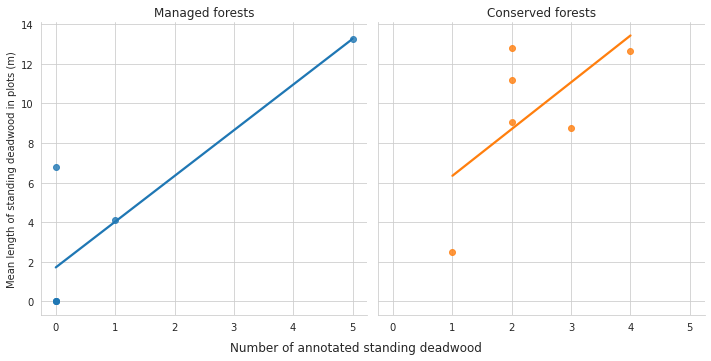

In [58]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_ann', y='l_udw_mean', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Mean length of standing deadwood in plots (m)')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Number of annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

Text(0.5, 1.0, 'Conserved forests')

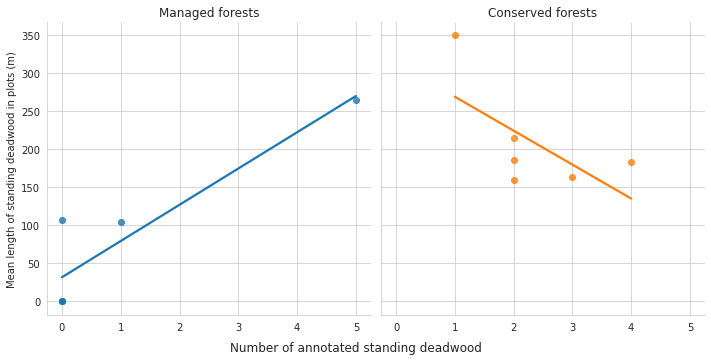

In [59]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_ann', y='d_udw_mean', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Mean length of standing deadwood in plots (m)')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Number of annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

Text(0.5, 1.0, 'Conserved forests')

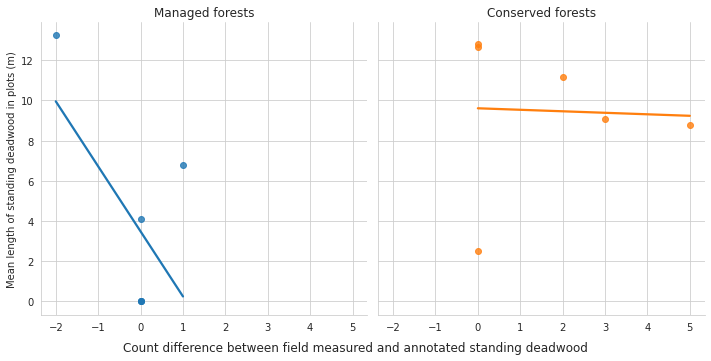

In [60]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot_diff', y='l_udw_mean', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Mean length of standing deadwood in plots (m)')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

Text(0.5, 1.0, 'Conserved forests')

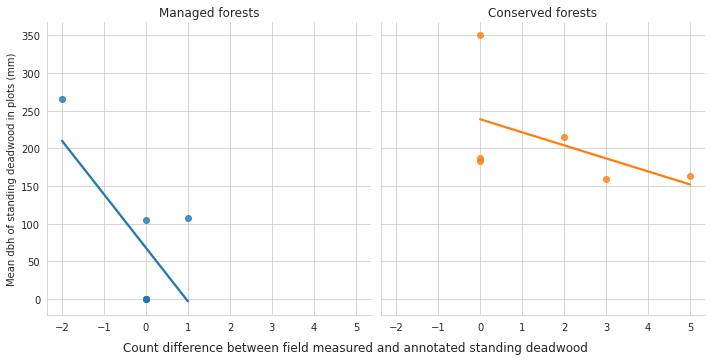

In [61]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot_diff', y='d_udw_mean', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Mean dbh of standing deadwood in plots (mm)')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

In [62]:
plot_dw_data['l_dw_plot_diff'] = plot_dw_data.l_ddw - plot_dw_data.l_gw_ann

Relation between canopy cover percentage and total lengths of groundwood in field plots.

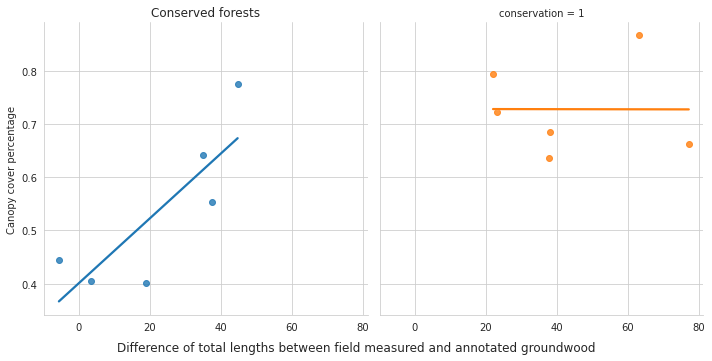

In [63]:
g = sns.lmplot(data=plot_dw_data, x='l_dw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Difference of total lengths between field measured and annotated groundwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][0].set_title('Conserved forests')

#g.map_dataframe(ann, **{'x_col':'l_dw_plot_diff', 'y_col':'canopy_cover_pct'})
plt.show()

In [64]:
anns_in_plots['v_ddw'] = anns_in_plots.geometry.apply(cut_cone_volume)

In [65]:
plot_dw_data['v_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer == 'groundwood')
                                                                       ].v_ddw.sum()
                                              , axis=1)

In [66]:
plot_dw_data['v_dw_plot'] = (plot_dw_data['v_dw']/10000)*np.pi*9**2
plot_dw_data['v_ddw_plot'] = (plot_dw_data['v_ddw']/10000)*np.pi*9**2
plot_dw_data['v_udw_plot'] = plot_dw_data.v_dw_plot - plot_dw_data.v_ddw_plot

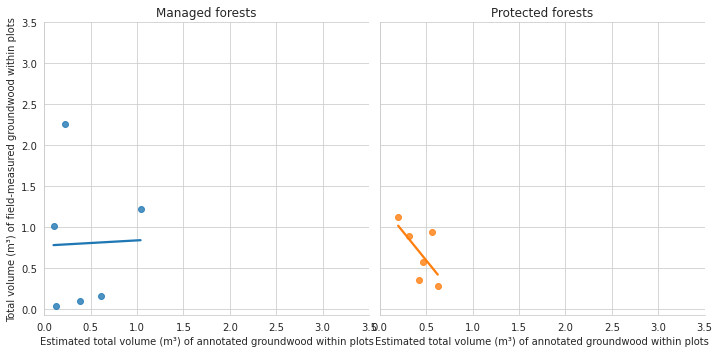

In [67]:
g = sns.lmplot(data=plot_dw_data, x='v_ddw_ann', y='v_ddw_plot', col='conservation', hue='conservation', #alpha=.8,
                legend=False, ci=0)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(np.arange(0,4,.5))
g.axes[0,0].set_xticks(np.arange(0,4,.5))
g.axes[0,1].set_xticks(np.arange(0,4,.5))
g.set_ylabels('Total volume (m³) of field-measured groundwood within plots')
g.set_xlabels('Estimated total volume (m³) of annotated groundwood within plots')
plt.show()

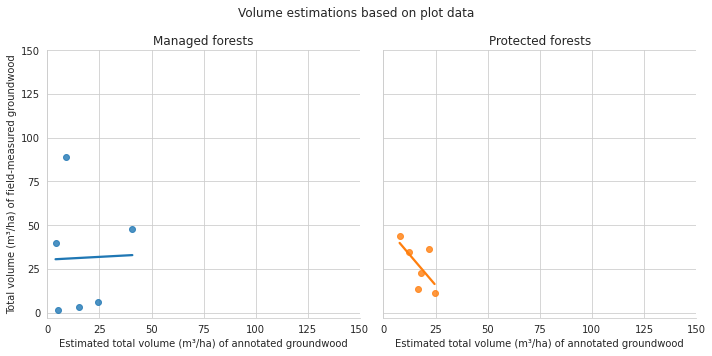

In [68]:
plot_dw_data['v_ddw_ann_ha'] = (10000 * plot_dw_data.v_ddw_ann) / (np.pi * 9**2)
g = sns.lmplot(data=plot_dw_data, x='v_ddw_ann_ha', y='v_ddw', col='conservation', hue='conservation', ci=0,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,151,25))
g.axes[0,0].set_xticks(range(0,151,25))
g.axes[0,1].set_xticks(range(0,151,25))
g.set_ylabels('Total volume (m³/ha) of field-measured groundwood')
g.set_xlabels('Estimated total volume (m³/ha) of annotated groundwood')
plt.suptitle('Volume estimations based on plot data')
plt.tight_layout()
plt.show()

In [69]:
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,1.476682,88.948335,31.362157,23.047994,34.526304,6
1,11.019677,44.052516,27.105068,28.626148,13.403048,6
All,1.476682,88.948335,29.233612,28.626148,25.068824,12


In [70]:
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw_ann_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha
conservation,,,,,,
0,3.946787,40.793841,16.320077,12.080675,14.120999,6
1,7.751047,24.516270,16.879035,17.353505,6.154216,6
All,3.946787,40.793841,16.599556,15.850944,10.389340,12


In [71]:
plot_dw_data['v_ddw_diff'] = plot_dw_data.v_ddw - plot_dw_data.v_ddw_ann_ha

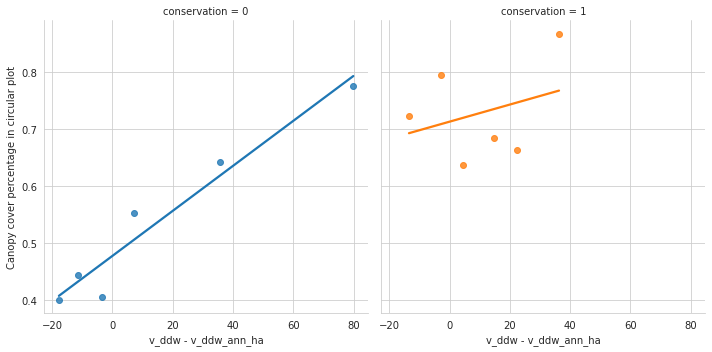

In [72]:
g = sns.lmplot(data=plot_dw_data, x='v_ddw_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('v_ddw - v_ddw_ann_ha')


# Sudenpesänkangas

Read data and do some wrangling.

In [189]:
evo_fd_path = Path('../data/sudenpesankangas/')
evo_anns = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')
evo_anns = evo_anns.to_crs('epsg:3067')
evo_preds = gpd.read_file('../results/sudenpesankangas/spk_merged.geojson')
evo_plot_circles = gpd.read_file(evo_fd_path/'plot_circles.geojson')
evo_plot_circles['id'] = evo_plot_circles['id'].astype(int)
evo_natura = gpd.read_file(evo_fd_path/'sudenpesankangas_natura.geojson')
evo_field_data = pd.read_csv(evo_fd_path/'puutiedot_sudenpesänkangas.csv', sep=';', decimal=',')
evo_field_data = gpd.GeoDataFrame(evo_field_data, geometry=gpd.points_from_xy(evo_field_data.gx, evo_field_data.gy), 
                                   crs='epsg:3067')
evo_grid = gpd.read_file(evo_fd_path/'vplots.geojson')
evo_grid = evo_grid.to_crs('epsg:3067')
evo_field_data['plotid'] = evo_field_data.kaid + 1000
evo_field_data = evo_field_data[evo_field_data.puuluo.isin([3,4])]

In [190]:
def match_plotid_spk(geom, plots):
    for r in plots.itertuples():
        if r.geometry.intersects(geom):
            return r.id
    return None

def match_vplot_spk(geom, plots):
    for p in plots.itertuples():
        if geom.intersects(p.geometry):
            return f'{p.fid}_{int(p.id)}'

Get up-to-date field data

In [191]:
evo_plots_updated = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018.txt', sep=' ')
evo_plots_luke = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018_LUKE.txt', sep=' ')
evo_plots_updated = gpd.GeoDataFrame(evo_plots_updated, geometry=gpd.points_from_xy(evo_plots_updated.x,
                                                                                    evo_plots_updated.y),
                                     crs='epsg:3067')
evo_plots_luke = gpd.GeoDataFrame(evo_plots_luke, geometry=gpd.points_from_xy(evo_plots_luke.x,
                                                                              evo_plots_luke.y),
                                     crs='epsg:3067')
evo_plots = pd.concat([evo_plots_updated, evo_plots_luke])
evo_plots.rename(columns= {c: c.replace('.','_') for c in evo_plots.columns}, inplace=True)

In [192]:
evo_plots['spk_id'] = evo_plots.geometry.apply(lambda row: match_plotid_spk(row, evo_plot_circles))

In [193]:
evo_plots.dropna(subset='spk_id', inplace=True)

In [194]:
evo_plots['geometry'] = evo_plots.spk_id.apply(lambda row: evo_plot_circles[evo_plot_circles.id == row].geometry.iloc[0])

In [195]:
evo_plots.drop(columns=['id'], inplace=True)
evo_plots.rename(columns={'spk_id': 'id'}, inplace=True)

In [196]:
evo_plots['conservation'] = evo_plots.geometry.apply(lambda row: 1 if evo_natura.geometry.unary_union.intersects(row)
                                                     else 0)

In [197]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: int(row.vplot_id.split('_')[1]), axis=1)

In [198]:
evo_plots = evo_plots[evo_plots.id.isin(evo_anns.plot_id.unique())]

In [199]:
evo_anns['plot_id'] = evo_anns.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_anns_in_plots = evo_anns[evo_anns.geometry.intersects(evo_plots.geometry.unary_union)].copy()

In [205]:
evo_preds['conservation'] = evo_preds.geometry.apply(lambda row: 1 if any(evo_natura.geometry.contains(row))
                                                         else 0)

In [206]:
evo_preds['vplot_id'] = evo_preds.geometry.apply(lambda row: match_vplot_spk(row, evo_grid))
evo_preds['plot_id'] = evo_preds.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_preds_in_plots = evo_preds[evo_preds.geometry.intersects(evo_plots.geometry.unary_union)].copy()
evo_preds_in_plots['plot_id'] = evo_preds_in_plots.plot_id.astype(int)

## Predictions vs annotations, all available data

In [211]:
pd.crosstab(evo_anns.conservation, evo_anns.label, margins=True)

label,groundwood,uprightwood,All
conservation,,,
0,569,61,630
1,3346,1358,4704
All,3915,1419,5334


In [214]:
pd.crosstab(evo_preds.conservation, evo_preds.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,583,77,660
1,3890,1235,5125
All,4473,1312,5785


In [215]:
evo_anns['tree_length'] = evo_anns.geometry.apply(get_len)
evo_preds['tree_length'] = evo_preds.geometry.apply(get_len)
evo_anns['diam'] = evo_anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
evo_preds['diam'] = evo_preds.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000

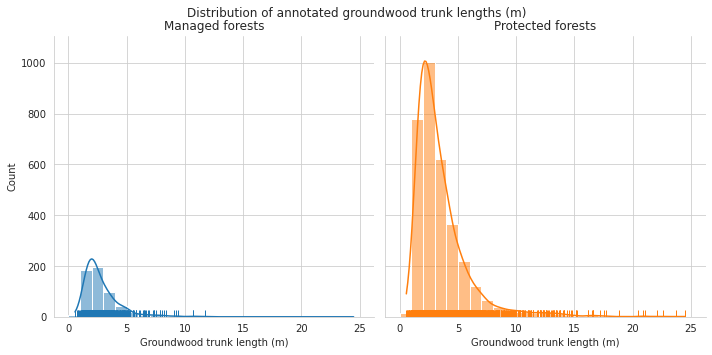

In [217]:
g = sns.displot(data=evo_anns[evo_anns.label=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(evo_anns.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

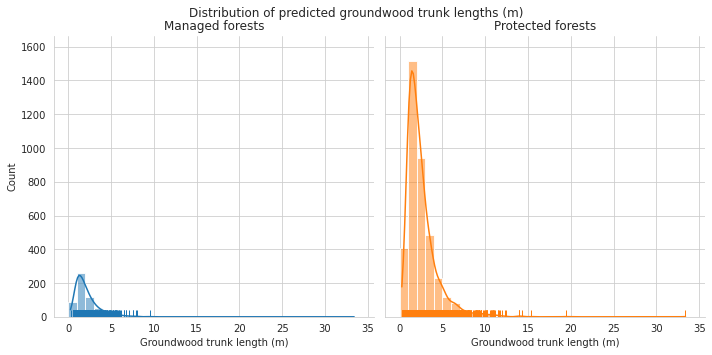

In [218]:
g = sns.displot(data=evo_preds[evo_preds.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(evo_preds.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

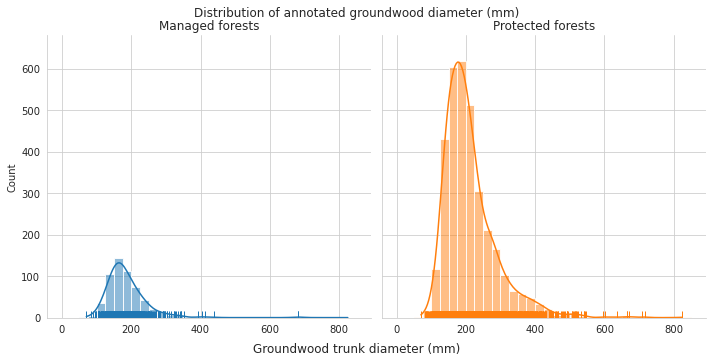

In [223]:
g = sns.displot(data=evo_anns[(evo_anns.label=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(evo_anns[(evo_anns.label=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

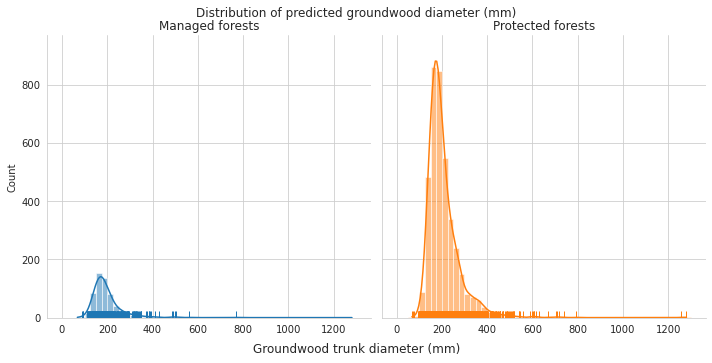

In [226]:
g = sns.displot(data=evo_preds[(evo_preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(evo_preds[(evo_preds.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

In [227]:
evo_anns['v_ddw'] = evo_anns.geometry.apply(cut_cone_volume)
evo_preds['v_ddw'] = evo_preds.geometry.apply(cut_cone_volume)

In [235]:
evo_vplot_area = evo_grid.area.sum()
evo_cons_area = evo_natura.overlay(evo_grid).area.sum()
evo_man_area = evo_tot_vplot_area - evo_cons_area
evo_man_ha = evo_man_area / 10000
evo_cons_ha = evo_cons_area / 10000

In [236]:
evo_ann_est_v_man = evo_anns[(evo_anns.label=='groundwood')&(evo_anns.conservation==0)].v_ddw.sum()/evo_man_ha
evo_ann_est_v_cons = evo_anns[(evo_anns.label=='groundwood')&(evo_anns.conservation==1)].v_ddw.sum()/evo_cons_ha
evo_ann_est_v = evo_anns[(evo_anns.label=='groundwood')].v_ddw.sum()/(evo_vplot_area/10000)

In [240]:
evo_pred_est_v_man = evo_preds[(evo_preds.layer=='groundwood')&(evo_preds.conservation==0)].v_ddw.sum()/evo_man_ha
evo_pred_est_v_cons = evo_preds[(evo_preds.layer=='groundwood')&(evo_preds.conservation==1)].v_ddw.sum()/evo_cons_ha
evo_pred_est_v = evo_preds[(evo_preds.layer=='groundwood')].v_ddw.sum()/(evo_vplot_area/10000)

In [241]:
print(f'Estimated groundwood volume in managed forests, based on annotations: {evo_ann_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on annotations: {evo_ann_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on annotations: {evo_ann_est_v:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on annotations: 4.46 ha/m³
Estimated groundwood volume in conserved forests, based on annotations: 10.67 ha/m³
Estimated groundwood volume in both types, based on annotations: 9.47 ha/m³


In [242]:
print(f'Estimated groundwood volume in managed forests, based on predictions: {evo_pred_est_v_man:.2f} ha/m³')
print(f'Estimated groundwood volume in conserved forests, based on predictions: {evo_pred_est_v_cons:.2f} ha/m³')
print(f'Estimated groundwood volume in both types, based on predictions: {evo_pred_est_v:.2f} ha/m³')

Estimated groundwood volume in managed forests, based on predictions: 4.41 ha/m³
Estimated groundwood volume in conserved forests, based on predictions: 10.75 ha/m³
Estimated groundwood volume in both types, based on predictions: 9.52 ha/m³


## Predictions vs field data, plot-wise

Add canopy density based on LiDAR derived canopy height model. The density is the percentage of field plot area with height above 2 meters.

In [243]:
pcts = []

with rio.open('../../data/raw/sudenpesankangas/full_mosaics/sudenpesankangas_chm.tif') as src:
    for row in evo_plots.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

In [244]:
evo_plots['canopy_cover_pct'] = pcts

In [62]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['canopy_cover_pct'],
               aggfunc=['min', 'max', 'mean', 'std', 'count'], margins=True)

,min,max,mean,std,count
,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct
conservation,,,,,
0,0.237288,0.959839,0.676011,0.264467,14
1,0.491036,0.991992,0.853076,0.113649,57
All,0.237288,0.991992,0.818162,0.168393,71


Count the number of deadwood instances similarly as for Hiidenportti data and plot the relationship between them.

In [246]:
evo_plots['n_dw_ann'] = evo_plots.apply(lambda row: evo_anns.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label!='groundwood'].plot_id.unique() else 0, axis=1)

evo_plots['n_dw_plot'] = np.round((evo_plots['n_dw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_ddw_plot'] = np.round((evo_plots['n_ddw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_udw_plot'] = evo_plots.n_dw_plot - evo_plots.n_ddw_plot
evo_plots['conservation'] = evo_plots.apply(lambda row: 1 if any(evo_natura.geometry.contains(row.geometry))
                                                        else 0, axis=1)

In [245]:
evo_plots['n_dw_pred'] = evo_plots.apply(lambda row: evo_preds.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_pred'] = evo_plots.apply(lambda row: evo_preds[evo_preds.layer=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds[evo_preds.layer=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_pred'] = evo_plots.apply(lambda row: evo_preds[evo_preds.layer!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_preds[evo_preds.layer!='groundwood'].plot_id.unique() else 0, axis=1)



In [247]:
evo_plots.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 'n_ddw_ann', 'n_udw_ann', 
                                                    'n_ddw_pred', 'n_udw_pred'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_ddw_pred,n_udw_ann,n_udw_plot,n_udw_pred
conservation,,,,,,
0,22,3,15,8,15,9
1,65,40,87,35,145,36
All,87,43,102,43,160,45


Plot the relationship between annotated and field data.

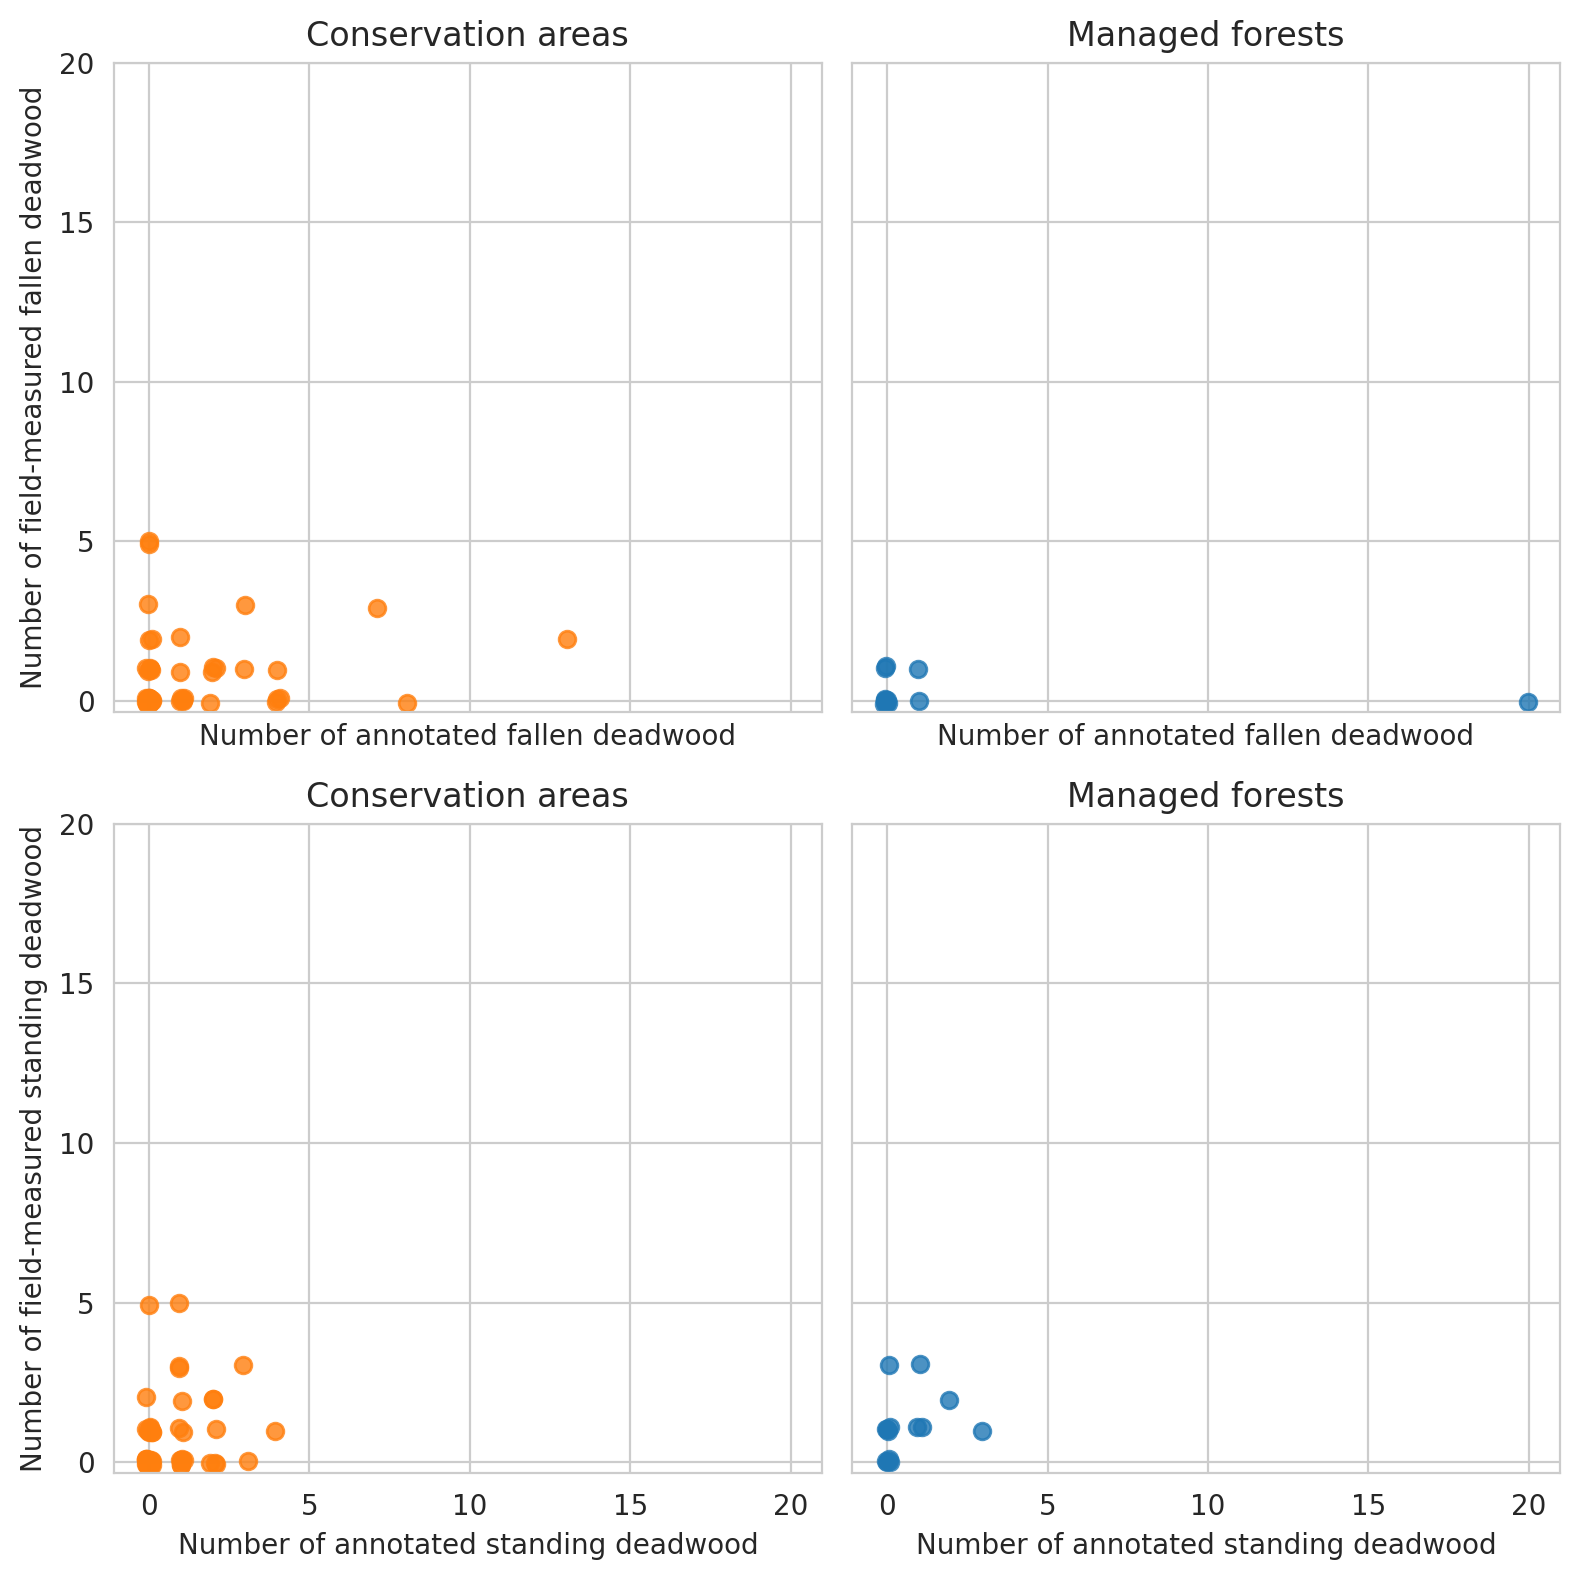

In [248]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_ddw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
plt.tight_layout()

Same for field data and predictions.

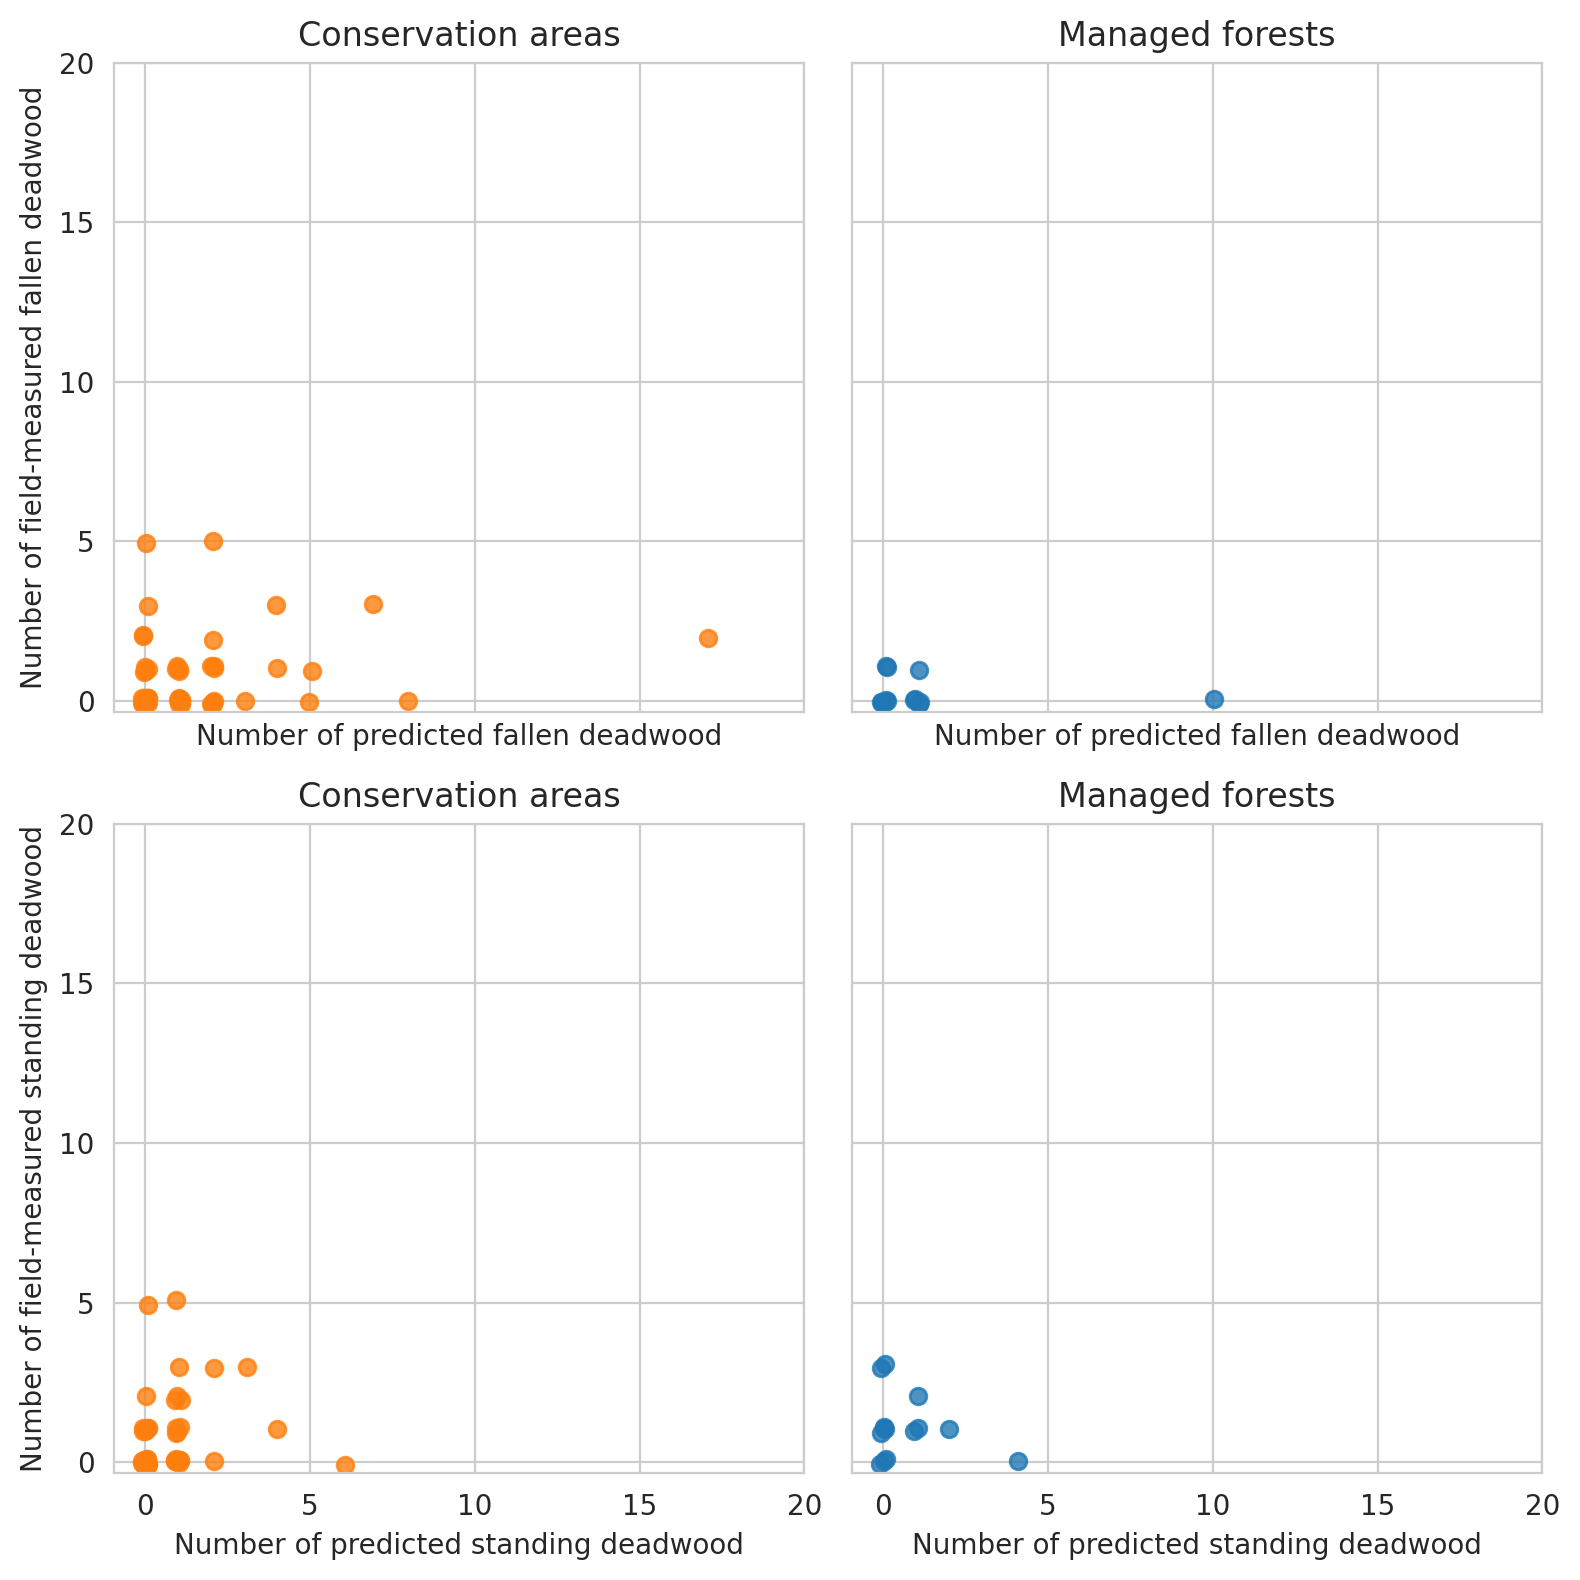

In [255]:
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xticks(range(0,21,5))
ax[0,0].set_xticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of predicted fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_pred', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xticks(range(0,21,5))
ax[0,1].set_xticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of predicted fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_pred', y='n_ddw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of predicted standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
ax[1,0].set_xticks(range(0,21,5))
ax[1,0].set_xticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_pred', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of predicted standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
ax[1,1].set_xticks(range(0,21,5))
ax[1,1].set_xticklabels(range(0,21,5))
plt.tight_layout()

As Evo data doesn't have field-measured deadwood lengths, we can't plot that relationship. We can, however, plot the DBH distributions, even though Evo dataset only has around 50 downed deadwood with dbh measured.

In [256]:
evo_field_data = evo_field_data[evo_field_data.plotid.isin(evo_plots.id.unique())]

In [257]:
evo_field_data['conservation'] = evo_field_data.apply(lambda row: evo_plots[evo_plots.id == row.plotid].conservation.unique()[0], axis=1)

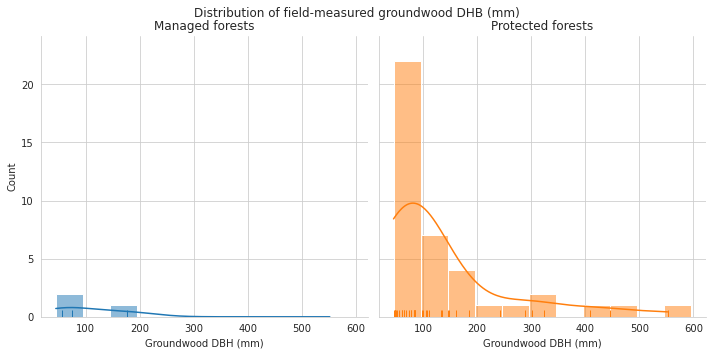

In [258]:
g = sns.displot(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)], 
                x='lapimitta_mm', hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=50) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood DBH (mm)')
plt.show()

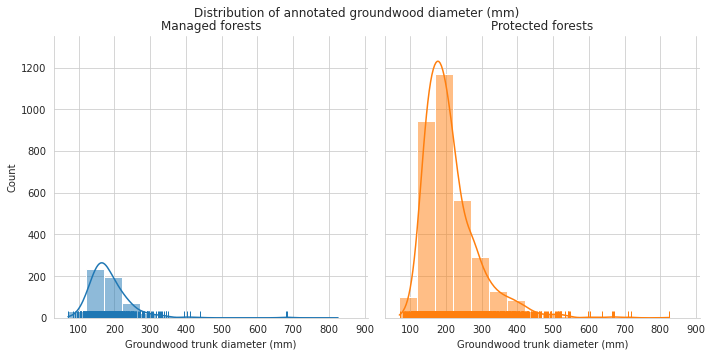

In [260]:
evo_anns_in_plots['diam'] = evo_anns_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=evo_anns[(evo_anns.label=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, binwidth=50) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()

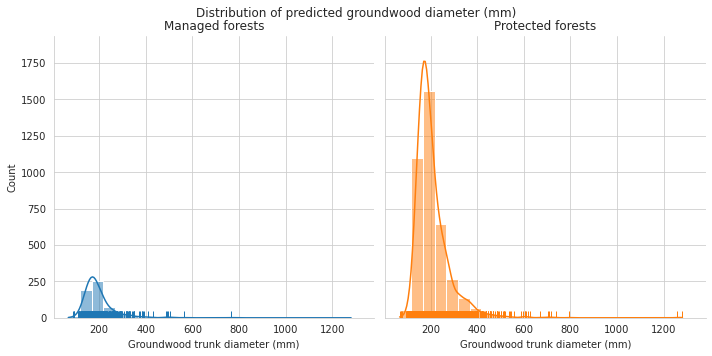

In [262]:
evo_preds_in_plots['diam'] = evo_preds_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=evo_preds[(evo_preds.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, binwidth=50) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of predicted groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()

In [269]:
evo_anns_in_plots['v_ddw'] = evo_anns_in_plots.geometry.apply(cut_cone_volume)
evo_plots['v_ddw_ann'] = evo_plots.apply(lambda row: evo_anns_in_plots[(evo_anns_in_plots.plot_id == row.id) &
                                                              (evo_anns_in_plots.label == 'groundwood')
                                                              ].v_ddw.sum()
                                              , axis=1)

In [272]:
evo_preds_in_plots['v_ddw'] = evo_preds_in_plots.geometry.apply(cut_cone_volume)
evo_plots['v_ddw_pred'] = evo_plots.apply(lambda row: evo_preds_in_plots[(evo_preds_in_plots.plot_id == row.id) &
                                                              (evo_preds_in_plots.layer == 'groundwood')
                                                              ].v_ddw.sum()
                                              , axis=1)

In [273]:
evo_plots['v_ddw_ann_ha'] = (10000 * evo_plots.v_ddw_ann) / (np.pi * 9**2)
evo_plots['v_ddw_pred_ha'] = (10000 * evo_plots.v_ddw_pred) / (np.pi * 9**2)

In [274]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,0.0,7.873780,0.661535,0.0,2.094276,14
1,0.0,123.004587,7.131762,0.0,23.939949,57
All,0.0,123.004587,5.855943,0.0,21.587804,71


In [275]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw_ann_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha
conservation,,,,,,
0,0.0,27.490278,2.644301,0.0,7.355574,14
1,0.0,240.684389,12.333702,0.0,36.917861,57
All,0.0,240.684389,10.423116,0.0,33.398580,71


In [276]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw_pred_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha,v_ddw_pred_ha
conservation,,,,,,
0,0.0,20.017281,2.635759,0.000000,5.343824,14
1,0.0,160.855433,8.097544,1.261027,22.710667,57
All,0.0,160.855433,7.020573,1.147933,20.559977,71
